# Projeto 3 
### Álan Carvalho - 118023615 
### Victor Hugo Rizzo - 118025308

## Importando as bibliotecas necessárias no estudo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


## Leitura das bases 

In [2]:
feat_train = pd.read_csv('dataset/train_images.csv', header = None)
resp_train = pd.read_csv('dataset/train_labels.csv')

feat_test = pd.read_csv('dataset/test_images.csv', header = None)
resp_test = pd.read_csv('dataset/test_labels.csv')

## Verificando o comportamento de uma foto aleatória

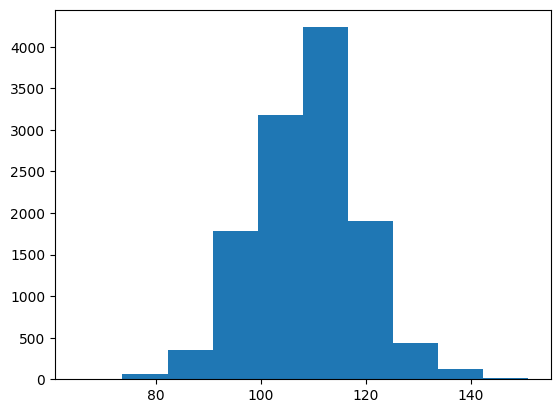

3445


In [3]:
r = np.random.randint(1, 7000)
plt.hist(feat_train.values[r])
plt.show()
print(r)

## Verificando o comportamento do pixel 350, escolhido ao acaso

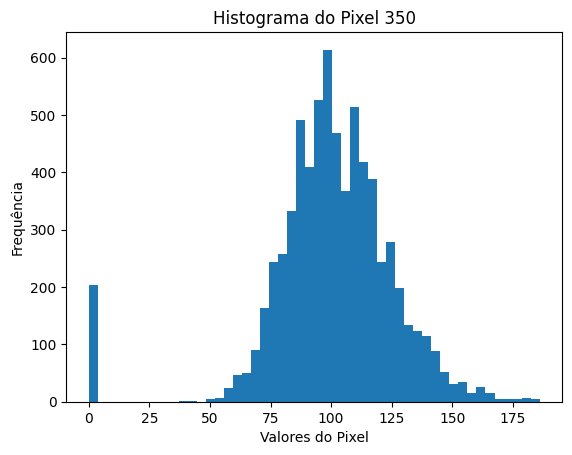

234

In [4]:
valores_pixel_350 = feat_train.iloc[:, 350].tolist()

plt.hist(valores_pixel_350, bins=50)
plt.title('Histograma do Pixel 350')
plt.xlabel('Valores do Pixel')
plt.ylabel('Frequência')
plt.show()

feat_train.max().max()


### Podemos perceber que tanto a imagem quanto o pixel possuem um comportamento semelhante ao de uma normal.

#

## Redimensionando a imagem visando utilizar uma região central 10x10

In [5]:
def obter_centro_10x10(imagem):
    imagem_reshaped = imagem.values.reshape(110, 110)

    altura, largura = imagem_reshaped.shape
    
    inicio_x, inicio_y = int((largura - 10) / 2), int((altura - 10) / 2)
    
    fim_x, fim_y = inicio_x + 10, inicio_y + 10
    
    centro_10x10 = imagem_reshaped[inicio_y:fim_y, inicio_x:fim_x]

    return centro_10x10.flatten() 

## Redimensionando os dataframes

In [6]:
feat_train_10x10 = feat_train.apply(obter_centro_10x10, axis=1)
feat_train_10x10 = pd.DataFrame(list(feat_train_10x10))

feat_test_10x10 = feat_test.apply(obter_centro_10x10, axis=1)
feat_test_10x10 = pd.DataFrame(list(feat_test_10x10))

print(feat_train_10x10.head())

    0    1    2    3    4    5    6    7    8    9   ...   90   91   92   93  \
0  116  111  114  101  100  100  104  100   94   89  ...  106  111  118  125   
1   91   95   93   81   73   77   77   86   96  102  ...   88   89   91   98   
2  108   91   64   71   89   98  109  125  106   94  ...   97  102  111  103   
3  100  103   89  104   77   98  124  142  129   65  ...  122  120  105   92   
4  113  106  109  121  123  130  123  115  113  100  ...  106   86  111  118   

    94   95   96   97   98   99  
0  108  104  114  111  101  103  
1  101  100   96   87   89   86  
2   88   78   88   83   68   98  
3  119  116   72  105  110  131  
4  113   88   97  113  121  116  

[5 rows x 100 columns]


## Transformando os valores entre 0 e 1

In [7]:
feat_train = feat_train/feat_train.max().max()
feat_test = feat_test/feat_test.max().max()
feat_train_10x10 = feat_train_10x10/feat_train_10x10.max().max()
feat_test_10x10 = feat_test_10x10/feat_test_10x10.max().max()

In [8]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(12, 10))
    index = 1
    for x in zip(images, title_texts):
        image = x[0].reshape(110, 110)
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1
        
def show_images10x10(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(12, 10))
    index = 1
    for x in zip(images, title_texts):
        image = x[0].reshape(10, 10)
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

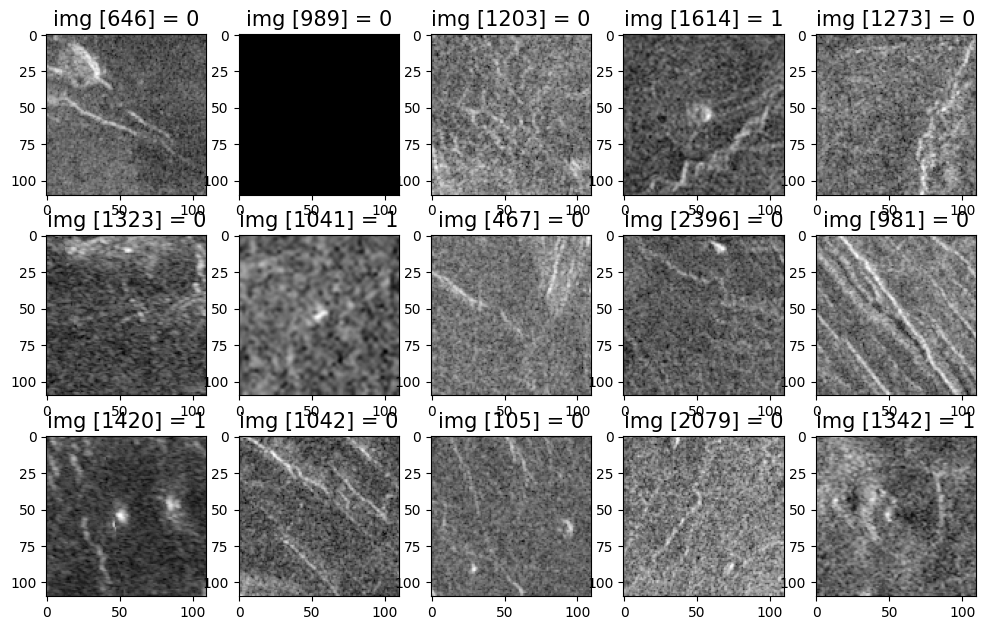

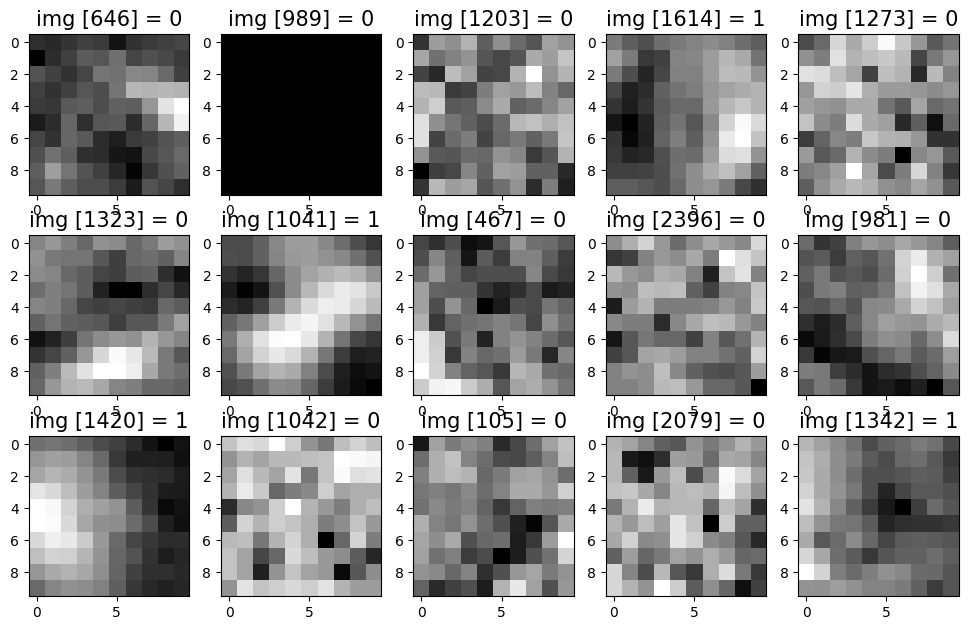

In [9]:
random_images_110 = []
random_images_10 = []
for i in range(0, 15):
    r = np.random.randint(1, 2734)
    random_images_110.append((feat_test.values[r], 'img [' + str(r) + '] = ' + str(resp_test["Volcano?"][r])))
    random_images_10.append((feat_test_10x10.values[r], 'img [' + str(r) + '] = ' + str(resp_test["Volcano?"][r])))

show_images(list(map(lambda x: x[0], random_images_110)), list(map(lambda x: x[1], random_images_110)))
show_images10x10(list(map(lambda x: x[0], random_images_10)), list(map(lambda x: x[1], random_images_10)))

## Definindo algumas funções que serão utilizadas

In [10]:
def matprint(mat, fmt="g", round_dig = 0):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            if round_dig == 0:
                print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
            else:
                print(("{:"+str(col_maxes[i])+fmt+"}").format(round(y, round_dig)), end="  ")
        print("")

In [11]:
def accuracy(clf, X_test, y_test ):
    CM = confusion_matrix(y_test, clf.predict(X_test))
    
    Pop = np.size(y_test)
    VN = CM[0, 0]
    VP = CM[1, 1]
    Acc = (VN + VP)/Pop
    
    return Acc

In [12]:
def falsoPos (clf, X_test, y_test ):    
    CM = confusion_matrix(y_test, clf.predict(X_test))

    N = np.size(np.where(y_test == 0))

    FP = CM[0, 1]

    FPR = FP/N
    
    return FPR

In [43]:
def falsoNeg (clf, X_test, y_test ):    
    CM = confusion_matrix(y_test, clf.predict(X_test))

    N = np.size(np.where(y_test == 0))

    FN = CM[1, 0]

    FNR = FN/N
    
    return FNR

In [14]:
def metrics(clf, X_test, y_test, score_f1 = False ,  gridsearch = False):

    CM = confusion_matrix(y_test, clf.predict(X_test))

    Pop = np.size(y_test)
    N = np.size(np.where(y_test == 0))
    P = np.size(np.where(y_test == 1))

    VN = CM[0, 0]
    FP = CM[0, 1]
    FN = CM[1, 0]
    VP = CM[1, 1]

    Prev = P/Pop
    Acc = (VN + VP)/Pop

    FPR = FP/N
    TNR = VN/N
    TPR = VP/P
    FNR = FN/P

    FOR = FN/(VN + FN)
    PPV = VP/(FP + VP)
    NPV = VN/(VN + FN)
    FDR = FP/(FP + VP)
    
    F1 = 2/(1/PPV + 1/TPR)
    
    if score_f1 == True:
        return F1
    else:
        print('\nMatriz de confusão:')
        matprint(CM)
    
        print("\n Métricas: \n")
    
        print('Prevalência:', Prev)
        print('Acurácia:', Acc)


        print('\nTaxa de falsos positivos:', FPR)
        print('Taxa de verdadeiros negativos (Especificidade):', TNR)
        print('Taxa de verdadeiros positivos (Recall):', TPR)
        print('Taxa de falsos negativos:', FNR)

        print('\nFalse omission rate:', FOR)
        print('Valor preditivo positivo (Precisão):', PPV)
        print('Valor preditivo negativo:', NPV)
        print('False discovery rate:', FDR)

        print('\nF1 Score:', F1)

In [47]:
def function_svc(svc, X_train, y_train, X_test, y_test, gridsearch = False):
    print('==== MÉTRICAS ====')
    if gridsearch:
        print('Quantidade de vetores-suporte: ', svc.best_estimator_.support_.size)
    else:
        print('Quantidade de vetores-suporte: ', svc.support_.size)

    CM = confusion_matrix(y_test, svc.predict(X_test))

    Pop = np.size(y_test)
    N = np.size(np.where(y_test == 0))
    P = np.size(np.where(y_test == 1))

    VN = CM[0, 0]
    FP = CM[0, 1]
    FN = CM[1, 0]
    VP = CM[1, 1]

    Prev = P/Pop
    Acc = (VN + VP)/Pop

    FPR = FP/N
    TNR = VN/N
    TPR = VP/P
    FNR = FN/P

    FOR = FN/(VN + FN)
    PPV = VP/(FP + VP)
    NPV = VN/(VN + FN)
    FDR = FP/(FP + VP)

    F1 = 2/(1/PPV + 1/TPR)
    
    print('\nMatriz de confusão:')
    matprint(CM)
    
    print('Prevalência:', Prev)
    print('Acurácia:', Acc)


    print('\nTaxa de falsos positivos:', FPR)
    print('Taxa de verdadeiros negativos (Especificidade):', TNR)
    print('Taxa de verdadeiros positivos (Recall):', TPR)
    print('Taxa de falsos negativos:', FNR)

    print('\nFalse omission rate:', FOR)
    print('Valor preditivo positivo (Precisão):', PPV)
    print('Valor preditivo negativo:', NPV)
    print('False discovery rate:', FDR)

    print('\nF1 Score:', F1)

In [16]:
def predicoes (clf):

  predicoes = clf.predict(feat_test_10x10.values)

  predicoes_corretas = []
  predicoes_erradas = []

  for i in range(len(predicoes)):
    if predicoes[i] == resp_test["Volcano?"].iloc[i]:
      predicoes_corretas.append(i)

    else:
      predicoes_erradas.append(i)

  qtd_pred_corretas = len(predicoes_corretas)
  qtd_pred_erradas = len(predicoes_erradas)
  qtd_pred_totais = qtd_pred_corretas + qtd_pred_erradas


  score_train = clf.score(feat_train_10x10.values, resp_train["Volcano?"].values)
  score_test = clf.score(feat_test_10x10.values, resp_test["Volcano?"].values)  


  print("Predições corretas: {0}; Predições incorretas: {1}"
        .format(str(qtd_pred_corretas), str(qtd_pred_erradas) ))

  print("Taxa de acerto: {0:.2f}% \n".format( 100 * qtd_pred_corretas/qtd_pred_totais ))

  print("Acurácia no treino: {0}; Acurácia no teste: {1}".format(score_train, score_test))
  print("Diferença na acurácia: {0:.4f}; Inflação na acurácia: {1:.4f}%"
        .format(score_train - score_test, 100 * (1 - (score_test/score_train))))

## Modelos

### Naive Bayes

In [17]:
gnb = GaussianNB()

gnb = gnb.fit(feat_train_10x10, resp_train["Volcano?"])

NB_predicoes = predicoes(gnb)

Predições corretas: 1452; Predições incorretas: 1282
Taxa de acerto: 53.11% 

Acurácia no treino: 0.6021428571428571; Acurácia no teste: 0.5310899780541332
Diferença na acurácia: 0.0711; Inflação na acurácia: 11.8000%


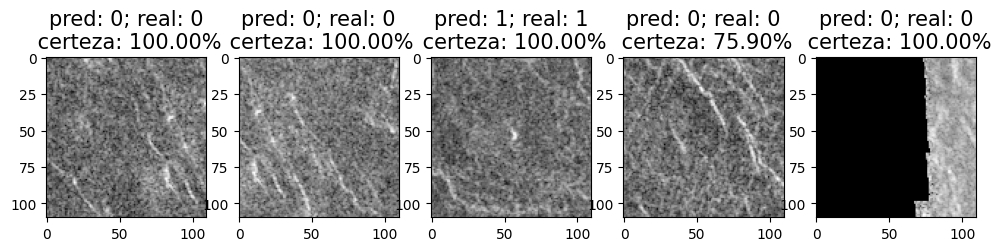

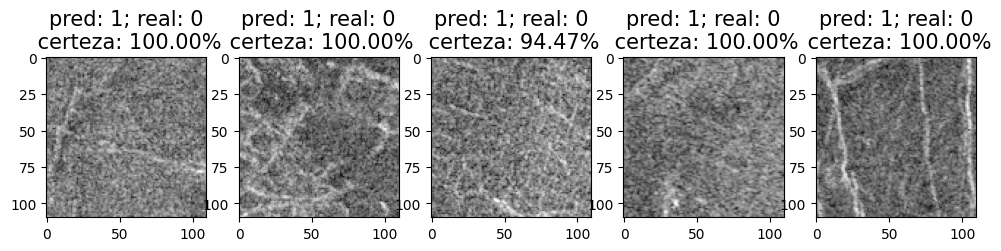

In [18]:
# Escolhe aleatoriamente as imagens, exibe o vetor de probabilidades informado pelo nosso classificador, bem como as predições e rótulos

predicoes_nb = gnb.predict(feat_test_10x10)
predicoes_prob_nb = gnb.predict_proba(feat_test_10x10)

predicoes_corretas = []
predicoes_erradas = []

for i in range(len(predicoes_nb)):
  if predicoes_nb[i] == resp_test["Volcano?"].iloc[i]:
    predicoes_corretas.append(i)

  else:
    predicoes_erradas.append(i)

indices_aleatorios_corretas = []
for i in range(5):
  indices_aleatorios_corretas.append( predicoes_corretas[np.random.randint(0, len(predicoes_corretas))] )

indices_aleatorios_erradas = []
for i in range(5):
  indices_aleatorios_erradas.append( predicoes_erradas[np.random.randint(0, len(predicoes_erradas))] )

imgs_corretas = []
pred_imgs_corretas = []

imgs_erradas = []
pred_imgs_erradas = []

for indice in indices_aleatorios_corretas:
  imgs_corretas.append([feat_test.iloc[indice]])
  pred_imgs_corretas.append("pred: {0}; real: {1}\n certeza: {2:.2f}%".format(
    predicoes_nb[indice], resp_test["Volcano?"].iloc[indice],
      100 * predicoes_prob_nb[indice][int(predicoes_nb[indice])]))

for indice in indices_aleatorios_erradas:
  imgs_erradas.append([feat_test.iloc[indice]])
  pred_imgs_erradas.append("pred: {0}; real: {1}\n certeza: {2:.2f}%".format(
    predicoes_nb[indice], resp_test["Volcano?"].iloc[indice],
      100 * predicoes_prob_nb[indice][int(predicoes_nb[indice])]))

show_images(np.array(imgs_corretas), pred_imgs_corretas)
show_images(np.array(imgs_erradas), pred_imgs_erradas)

In [19]:
NB_metrics = metrics(gnb, feat_test_10x10, resp_test['Volcano?'])
NB_metrics


Matriz de confusão:
1088  1212  
  70   364  

 Métricas: 

Prevalência: 0.15874177029992684
Acurácia: 0.5310899780541332

Taxa de falsos positivos: 0.5269565217391304
Taxa de verdadeiros negativos (Especificidade): 0.47304347826086957
Taxa de verdadeiros positivos (Recall): 0.8387096774193549
Taxa de falsos negativos: 0.16129032258064516

False omission rate: 0.06044905008635579
Valor preditivo positivo (Precisão): 0.23096446700507614
Valor preditivo negativo: 0.9395509499136442
False discovery rate: 0.7690355329949239

F1 Score: 0.36218905472636814


## LDA

In [20]:
lda = LinearDiscriminantAnalysis()

lda = lda.fit(feat_train_10x10, resp_train["Volcano?"])

LDA_predicoes = predicoes(lda)

Predições corretas: 2445; Predições incorretas: 289
Taxa de acerto: 89.43% 

Acurácia no treino: 0.9101428571428571; Acurácia no teste: 0.8942940746159473
Diferença na acurácia: 0.0158; Inflação na acurácia: 1.7414%


In [21]:
LDA_metrics = metrics(lda, feat_test_10x10, resp_test['Volcano?'])
LDA_metrics


Matriz de confusão:
2249   51  
 238  196  

 Métricas: 

Prevalência: 0.15874177029992684
Acurácia: 0.8942940746159473

Taxa de falsos positivos: 0.02217391304347826
Taxa de verdadeiros negativos (Especificidade): 0.9778260869565217
Taxa de verdadeiros positivos (Recall): 0.45161290322580644
Taxa de falsos negativos: 0.5483870967741935

False omission rate: 0.09569762766385204
Valor preditivo positivo (Precisão): 0.7935222672064778
Valor preditivo negativo: 0.904302372336148
False discovery rate: 0.20647773279352227

F1 Score: 0.5756240822320118


## QDA

In [22]:
qda = QuadraticDiscriminantAnalysis()

qda = qda.fit(feat_train_10x10, resp_train["Volcano?"])

QDA_predicoes = predicoes(qda)

Predições corretas: 2449; Predições incorretas: 285
Taxa de acerto: 89.58% 

Acurácia no treino: 0.9487142857142857; Acurácia no teste: 0.89575713240673
Diferença na acurácia: 0.0530; Inflação na acurácia: 5.5820%


In [23]:
QDA_metrics = metrics(qda, feat_test_10x10, resp_test['Volcano?'])
QDA_metrics


Matriz de confusão:
2167  133  
 152  282  

 Métricas: 

Prevalência: 0.15874177029992684
Acurácia: 0.89575713240673

Taxa de falsos positivos: 0.05782608695652174
Taxa de verdadeiros negativos (Especificidade): 0.9421739130434783
Taxa de verdadeiros positivos (Recall): 0.6497695852534562
Taxa de falsos negativos: 0.35023041474654376

False omission rate: 0.06554549374730487
Valor preditivo positivo (Precisão): 0.6795180722891566
Valor preditivo negativo: 0.9344545062526951
False discovery rate: 0.3204819277108434

F1 Score: 0.6643109540636043


## KNN

In [24]:
feat_train_10x10.dropna(inplace=True)
feat_test_10x10.dropna(inplace=True)
resp_train["Volcano?"].dropna(inplace = True)
resp_test["Volcano?"].dropna(inplace = True)


In [25]:
KNN = KNeighborsClassifier()
param_grid_KNN = {"n_neighbors": range(1,70)}
KNNCV = GridSearchCV(KNN, param_grid = param_grid_KNN, scoring='accuracy', cv = 5, verbose = 1, n_jobs=-1)

In [26]:
KNNCV.fit(feat_train_10x10.values, resp_train["Volcano?"].values)
print("\n Melhor n_neighbours por validação cruzada: ", KNNCV.best_params_['n_neighbors'])

Fitting 5 folds for each of 69 candidates, totalling 345 fits



 Melhor n_neighbours por validação cruzada:  5


In [27]:
KNN_predicoes = predicoes(KNNCV)

Predições corretas: 2499; Predições incorretas: 235
Taxa de acerto: 91.40% 

Acurácia no treino: 0.9402857142857143; Acurácia no teste: 0.9140453547915143
Diferença na acurácia: 0.0262; Inflação na acurácia: 2.7907%


In [28]:
KNN_metrics = metrics(KNNCV, feat_test_10x10, resp_test['Volcano?'])
KNN_metrics


Matriz de confusão:
2263   37  
 198  236  

 Métricas: 

Prevalência: 0.15874177029992684
Acurácia: 0.9140453547915143

Taxa de falsos positivos: 0.01608695652173913
Taxa de verdadeiros negativos (Especificidade): 0.9839130434782609
Taxa de verdadeiros positivos (Recall): 0.543778801843318
Taxa de falsos negativos: 0.45622119815668205

False omission rate: 0.08045509955302722
Valor preditivo positivo (Precisão): 0.8644688644688645
Valor preditivo negativo: 0.9195449004469728
False discovery rate: 0.13553113553113552

F1 Score: 0.6676096181046677


## Árvore de Classificação

In [29]:
DTC = DecisionTreeClassifier()
param_grid_DTC = {
    'max_depth': [None, 5, 10, 15],  # Profundidade máxima da árvore
    'min_samples_split': [3, 5, 10],  # Número mínimo de amostras para divisão
    'min_samples_leaf': [1, 3, 5],  # Número mínimo de amostras em um nó folha
    'max_features': [None, 'sqrt', 'log2'],  # Número máximo de features consideradas para divisão
    'criterion': ['gini', 'entropy']  # Critério de divisão
}

DTCV = GridSearchCV(DTC, param_grid=param_grid_DTC, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)



In [30]:
DTCV.fit(feat_train_10x10, resp_train["Volcano?"])

print("Melhores parâmetros: \n")

print("Critério utilizado para medir a qualidade de uma divisão: " , DTCV.best_params_['criterion'])
print("Profundidade máxima da árvore: ", DTCV.best_params_['max_depth'])
print("Máximo de atributos considerados para divisão: ", DTCV.best_params_['max_features'])
print("Mínimo de amostras em um nó: ", DTCV.best_params_['min_samples_leaf'])
print("Número mínimo de amostras para divisão ", DTCV.best_params_['min_samples_split'])



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Melhores parâmetros: 

Critério utilizado para medir a qualidade de uma divisão:  entropy
Profundidade máxima da árvore:  10
Máximo de atributos considerados para divisão:  None
Mínimo de amostras em um nó:  3
Número mínimo de amostras para divisão  3


In [31]:
DTCV_predicoes = predicoes(DTCV)

Predições corretas: 2396; Predições incorretas: 338
Taxa de acerto: 87.64% 

Acurácia no treino: 0.955; Acurácia no teste: 0.8763716166788588
Diferença na acurácia: 0.0786; Inflação na acurácia: 8.2333%


In [32]:
DTCV_metrics = metrics(DTCV, feat_test_10x10, resp_test['Volcano?'])
DTCV_metrics


Matriz de confusão:
2163  137  
 201  233  

 Métricas: 

Prevalência: 0.15874177029992684
Acurácia: 0.8763716166788588

Taxa de falsos positivos: 0.05956521739130435
Taxa de verdadeiros negativos (Especificidade): 0.9404347826086956
Taxa de verdadeiros positivos (Recall): 0.5368663594470046
Taxa de falsos negativos: 0.4631336405529954

False omission rate: 0.0850253807106599
Valor preditivo positivo (Precisão): 0.6297297297297297
Valor preditivo negativo: 0.9149746192893401
False discovery rate: 0.37027027027027026

F1 Score: 0.5796019900497512


## SVM

## Linear

In [33]:
param_svm_linear  = [{'C' : [0.001, 0.01, 0.1, 1, 3, 5, 10, 100, 1000, 10000]}]
svm_linear_cv = GridSearchCV(SVC(kernel = 'linear'), param_grid = param_svm_linear, cv = 5,
                             scoring = 'accuracy', verbose = 1, n_jobs = -1)

svm_linear_cv.fit(feat_train_10x10, resp_train['Volcano?'])

    
print('Best estimator:', svm_linear_cv.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best estimator: SVC(C=3, kernel='linear')


In [34]:
SVM_linear_predicoes = predicoes(svm_linear_cv)

Predições corretas: 2446; Predições incorretas: 288
Taxa de acerto: 89.47% 

Acurácia no treino: 0.9104285714285715; Acurácia no teste: 0.894659839063643
Diferença na acurácia: 0.0158; Inflação na acurácia: 1.7320%


In [48]:
SVM_linear_metrics = function_svc(svm_linear_cv , feat_train_10x10, resp_train['Volcano?'] , feat_test_10x10, resp_test['Volcano?'], gridsearch = True)

==== MÉTRICAS ====
Quantidade de vetores-suporte:  1792

Matriz de confusão:
2275   25  
 263  171  
Prevalência: 0.15874177029992684
Acurácia: 0.894659839063643

Taxa de falsos positivos: 0.010869565217391304
Taxa de verdadeiros negativos (Especificidade): 0.9891304347826086
Taxa de verdadeiros positivos (Recall): 0.39400921658986177
Taxa de falsos negativos: 0.6059907834101382

False omission rate: 0.10362490149724192
Valor preditivo positivo (Precisão): 0.8724489795918368
Valor preditivo negativo: 0.8963750985027581
False discovery rate: 0.12755102040816327

F1 Score: 0.5428571428571428


## Polinomial

In [36]:
param_poly = [{'C': [0.1, 1, 5, 10], 'gamma': [0.01, 0.1, 1], 'coef0': [-1, 0, 1], 'degree': [3, 5]}]

svm_poly_CV = GridSearchCV(SVC(kernel = 'poly'), param_grid = param_poly, cv = 5, scoring = 'accuracy', verbose = 10, n_jobs = -1)

svm_poly_CV.fit(feat_train_10x10, resp_train['Volcano?'])

print('Best estimator:', svm_poly_CV.best_estimator_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best estimator: SVC(C=0.1, coef0=1, gamma=1, kernel='poly')


In [37]:
SVM_poly_predicoes = predicoes(svm_poly_CV)

Predições corretas: 2546; Predições incorretas: 188
Taxa de acerto: 93.12% 

Acurácia no treino: 0.9608571428571429; Acurácia no teste: 0.9312362838332114
Diferença na acurácia: 0.0296; Inflação na acurácia: 3.0828%


In [49]:
SVM_poly_metrics = function_svc(svm_poly_CV , feat_train_10x10, resp_train['Volcano?'] , feat_test_10x10, resp_test['Volcano?'], gridsearch = True)

==== MÉTRICAS ====
Quantidade de vetores-suporte:  1391

Matriz de confusão:
2254   46  
 142  292  
Prevalência: 0.15874177029992684
Acurácia: 0.9312362838332114

Taxa de falsos positivos: 0.02
Taxa de verdadeiros negativos (Especificidade): 0.98
Taxa de verdadeiros positivos (Recall): 0.6728110599078341
Taxa de falsos negativos: 0.3271889400921659

False omission rate: 0.05926544240400668
Valor preditivo positivo (Precisão): 0.863905325443787
Valor preditivo negativo: 0.9407345575959933
False discovery rate: 0.13609467455621302

F1 Score: 0.7564766839378237


## RBF

In [39]:
param_rbf = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000, 5000, 10000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}]

svm_rbf_CV = GridSearchCV(SVC(kernel = 'rbf'), param_grid = param_rbf, cv = 5, scoring = 'accuracy', verbose = 4, n_jobs = -1)

svm_rbf_CV.fit(feat_train_10x10, resp_train['Volcano?'])

print('Best estimator:', svm_rbf_CV.best_estimator_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Best estimator: SVC(C=10, gamma=1)


In [40]:
SVM_rbf_predicoes = predicoes(svm_rbf_CV)

Predições corretas: 2538; Predições incorretas: 196
Taxa de acerto: 92.83% 

Acurácia no treino: 0.9817142857142858; Acurácia no teste: 0.9283101682516459
Diferença na acurácia: 0.0534; Inflação na acurácia: 5.4399%


In [50]:
SVM_rbf_metrics = function_svc(svm_rbf_CV , feat_train_10x10, resp_train['Volcano?'] , feat_test_10x10, resp_test['Volcano?'], gridsearch = True)

==== MÉTRICAS ====
Quantidade de vetores-suporte:  1783

Matriz de confusão:
2248   52  
 144  290  
Prevalência: 0.15874177029992684
Acurácia: 0.9283101682516459

Taxa de falsos positivos: 0.022608695652173914
Taxa de verdadeiros negativos (Especificidade): 0.9773913043478261
Taxa de verdadeiros positivos (Recall): 0.6682027649769585
Taxa de falsos negativos: 0.3317972350230415

False omission rate: 0.06020066889632107
Valor preditivo positivo (Precisão): 0.847953216374269
Valor preditivo negativo: 0.939799331103679
False discovery rate: 0.15204678362573099

F1 Score: 0.7474226804123711


In [45]:
print('F1 Score: \n')
print("NB: ", metrics(gnb, feat_test_10x10, resp_test['Volcano?'], score_f1 = True))
print("LDA: ", metrics(lda, feat_test_10x10, resp_test['Volcano?'], score_f1 = True))
print("QDA: ", metrics(qda, feat_test_10x10, resp_test['Volcano?'], score_f1 = True))
print("SVM linear: ", metrics(svm_linear_cv, feat_test_10x10, resp_test['Volcano?'], score_f1 = True))
print("SVM poly: ", metrics(svm_poly_CV, feat_test_10x10, resp_test['Volcano?'], score_f1 = True))
print("SVM rbf: ", metrics(svm_rbf_CV, feat_test_10x10, resp_test['Volcano?'], score_f1 = True))
print("KNN: ", metrics(KNNCV, feat_test_10x10, resp_test['Volcano?'], score_f1 = True))
print("TREE: ", metrics(DTCV, feat_test_10x10, resp_test['Volcano?'], score_f1 = True), "\n")

print('Acurácia no teste: \n')
print("NB: ", accuracy(gnb, feat_test_10x10, resp_test['Volcano?']))
print("LDA: ", accuracy(lda, feat_test_10x10, resp_test['Volcano?']))
print("QDA: ", accuracy(qda, feat_test_10x10, resp_test['Volcano?']))
print("SVM linear: ", accuracy(svm_linear_cv, feat_test_10x10, resp_test['Volcano?']))
print("SVM poly: ", accuracy(svm_poly_CV, feat_test_10x10, resp_test['Volcano?']))
print("SVM rbf: ", accuracy(svm_rbf_CV, feat_test_10x10, resp_test['Volcano?']))
print("KNN: ", accuracy(KNNCV, feat_test_10x10, resp_test['Volcano?']))
print("TREE: ", accuracy(DTCV, feat_test_10x10, resp_test['Volcano?']))

F1 Score: 

NB:  0.36218905472636814
LDA:  0.5756240822320118
QDA:  0.6643109540636043
SVM linear:  0.5428571428571428
SVM poly:  0.7564766839378237
SVM rbf:  0.7474226804123711
KNN:  0.6676096181046677
TREE:  0.5796019900497512 

Acurácia no teste: 

NB:  0.5310899780541332
LDA:  0.8942940746159473
QDA:  0.89575713240673
SVM linear:  0.894659839063643
SVM poly:  0.9312362838332114
SVM rbf:  0.9283101682516459
KNN:  0.9140453547915143
TREE:  0.8763716166788588


In [46]:
print('Taxa de falsos positivos: \n')
print("NB: ", falsoPos(gnb, feat_test_10x10, resp_test['Volcano?']))
print("LDA: ", falsoPos(lda, feat_test_10x10, resp_test['Volcano?']))
print("QDA: ", falsoPos(qda, feat_test_10x10, resp_test['Volcano?']))
print("SVM linear: ", falsoPos(svm_linear_cv, feat_test_10x10, resp_test['Volcano?']))
print("SVM poly: ", falsoPos(svm_poly_CV, feat_test_10x10, resp_test['Volcano?']))
print("SVM rbf: ", falsoPos(svm_rbf_CV, feat_test_10x10, resp_test['Volcano?']))
print("KNN: ", falsoPos(KNNCV, feat_test_10x10, resp_test['Volcano?']))
print("TREE: ", falsoPos(DTCV, feat_test_10x10, resp_test['Volcano?']), "\n")

print('Taxa de falsos negativos: \n')
print("NB: ", falsoNeg(gnb, feat_test_10x10, resp_test['Volcano?']))
print("LDA: ", falsoNeg(lda, feat_test_10x10, resp_test['Volcano?']))
print("QDA: ", falsoNeg(qda, feat_test_10x10, resp_test['Volcano?']))
print("SVM linear: ", falsoNeg(svm_linear_cv, feat_test_10x10, resp_test['Volcano?']))
print("SVM poly: ", falsoNeg(svm_poly_CV, feat_test_10x10, resp_test['Volcano?']))
print("SVM rbf: ", falsoNeg(svm_rbf_CV, feat_test_10x10, resp_test['Volcano?']))
print("KNN: ", falsoNeg(KNNCV, feat_test_10x10, resp_test['Volcano?']))
print("TREE: ", falsoNeg(DTCV, feat_test_10x10, resp_test['Volcano?']))

Taxa de falsos positivos: 

NB:  0.5269565217391304
LDA:  0.02217391304347826
QDA:  0.05782608695652174
SVM linear:  0.010869565217391304
SVM poly:  0.02
SVM rbf:  0.022608695652173914
KNN:  0.01608695652173913
TREE:  0.05956521739130435 

Taxa de falsos negativos: 

NB:  0.030434782608695653
LDA:  0.10347826086956521
QDA:  0.06608695652173913
SVM linear:  0.11434782608695652
SVM poly:  0.06173913043478261
SVM rbf:  0.06260869565217392
KNN:  0.08608695652173913
TREE:  0.08739130434782609


##

## Conclusão do estudo

### Após testarmos todos os classificadores, optamos por utilizar duas métricas para concluirmos qual seria o modelo ideal: a acurácia do modelo na base de teste, ou seja, o quanto o modelo acerta a previsão, e o F1-score que determina a qualidade do modelo. Vale ressaltar que nos modelos de SVM realizamos a otimização dos hiperparâmetros, visando alcançar o melhor estimador possível. Ao final, praticamente todos os classificadores se mostraram bons quando olhamos para a acurácia na base teste, exceto o Naive Bayes que teve um desempenho bastante inferior. O mesmo comportamento conseguimos observar no F1-Score. Ao analisarmos conjuntamente as duas métricas, observamos um certo equilíbrio (bom) entre os classificadores, mas com uma leve vantagem para o SVM polinomial, que por apresentar os melhores indicadores escolhemos como o modelo ideal para prever a existência ou não de vulcões na imagem.

### Quanto ao cuidado com falsos positivos e falsos negativos, ao analisarmos de um ponto de vista mais prático, acreditamos que depende da finalidade do estudo: no caso de falsos positivos, estaríamos classificando erroneamente uma região com vulcão quando na verdade não existiria. Isso poderia gerar investigações desnecessárias e/ou desperdício de recursos e tempo. Já no caso de falsos negativos, deixaríamos de detectar uma região onde existe de fato um vulcão, o que, do ponto de vista científico, seria pior, pois não estaríamos identificando vulcões reais. Em resumo, analisando do ponto de vista prático, depende da importância e prioridade do nosso problema.

### Por outro lado, ao analisarmos diretamente as métricas que medem a quantidade de falsos positivos e falsos negativos, a taxa ligeiramente mais alta é a de falsos negativos, entretanto não parece ser um grande problema visto que é uma taxa baixa e o modelo escolhido é o que apresenta a menor de todas.
